# Look at pairs
Here we just examine several neuron pairs to look at their symmetry in temms of
morphology and ipsilateral connection matching.

## Preliminaries

In [1]:
from pkg.utils import set_warnings

import datetime
import pprint
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from giskard.utils import get_paired_inds
from graspologic.align import OrthogonalProcrustes, SeedlessProcrustes
from graspologic.embed import AdjacencySpectralEmbed, select_dimension
from graspologic.utils import augment_diagonal, binarize, pass_to_ranks
from hyppo.ksample import KSample
from pkg.data import (
    load_maggot_graph,
    load_navis_neurons,
    load_network_palette,
    load_node_palette,
    select_nice_nodes,
)
from pkg.io import savefig
from pkg.plot import set_theme
from sklearn.metrics.pairwise import cosine_similarity
from src.pymaid import start_instance
from src.visualization import simple_plot_neurons


def stashfig(name, **kwargs):
    foldername = "latent_distribution_test"
    savefig(name, foldername=foldername, **kwargs)

## Load and process data

In [2]:

t0 = time.time()
set_theme()

network_palette, NETWORK_KEY = load_network_palette()
node_palette, NODE_KEY = load_node_palette()

mg = load_maggot_graph()
mg = select_nice_nodes(mg)
nodes = mg.nodes
left_nodes = nodes[nodes["hemisphere"] == "L"]
left_inds = left_nodes["_inds"]
right_nodes = nodes[nodes["hemisphere"] == "R"]
right_inds = right_nodes["_inds"]
left_paired_inds, right_paired_inds = get_paired_inds(
    nodes, pair_key="pair", pair_id_key="pair_id"
)
right_paired_inds_shifted = right_paired_inds - len(left_inds)
adj = mg.sum.adj

start_instance()
neurons = load_navis_neurons()

Removed 13 nodes when taking the largest connected component.
Removed 38 nodes when removing pendants.
Removed 0 nodes when taking the largest connected component.


## Plot neurons and connectivity
- The first column shows a coronal view (top is top of brain, bottom is bottom,
  view is as if we are looking at the maggot).
- The second column shows two rows of the adjacency matrix, one for each neuron in
  the pair. Several metrics are displayed - the top is the cosine similarity between
  these rows, and the number to the right is the union of the number of contacts that
  any neuron in the pair outputs to.
- The third columns shows the same idea as the second, but for inputs instead of
  outputs.

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

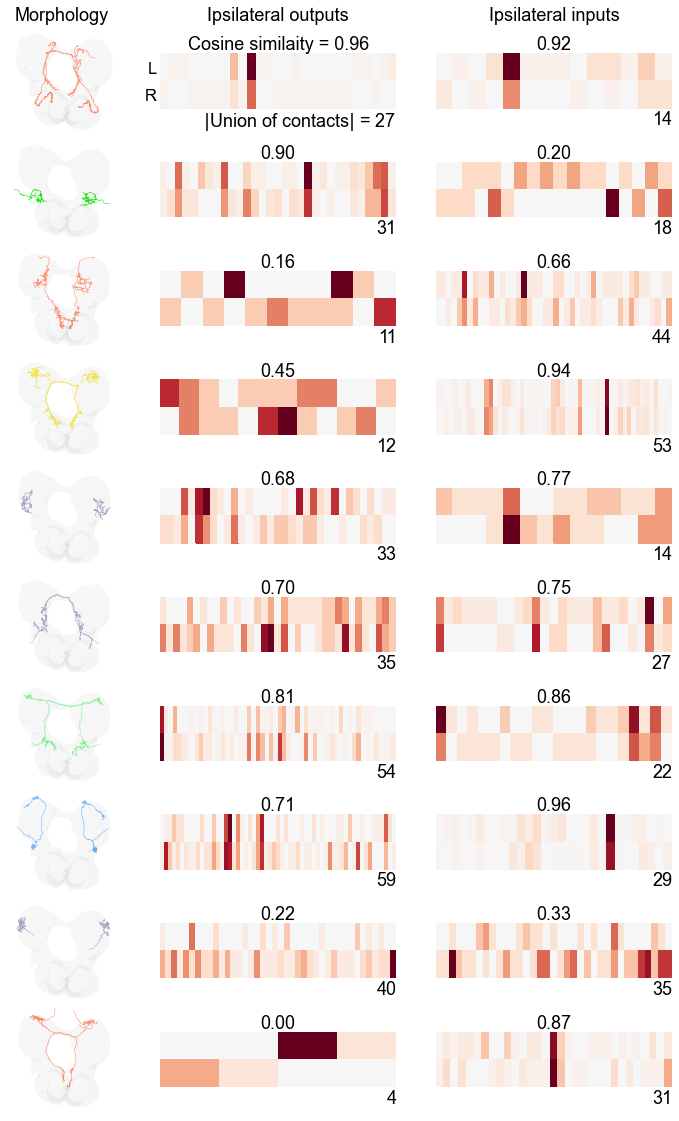

In [3]:
n_show_pairs = 10
n_col = 3
fig = plt.figure(figsize=(12, 2 * n_show_pairs))
gs = plt.GridSpec(
    n_show_pairs, n_col, figure=fig, hspace=0, width_ratios=[0.2, 0.4, 0.4]
)
# axs = np.empty((n_rows, n_cols), dtype=object)
skeleton_color_dict = dict(
    zip(nodes.index, np.vectorize(node_palette.get)(nodes[NODE_KEY]))
)
# 8888888
rng = np.random.default_rng(8888)
pair_ids = nodes[nodes["pair_id"] > 2]["pair_id"]
show_pair_ids = rng.choice(pair_ids, size=n_show_pairs)
for i, pair_id in enumerate(show_pair_ids):
    plot_neuron_ids = nodes[nodes["pair_id"] == pair_id].index
    plot_neuron_list = neurons.idx[plot_neuron_ids]
    # inds = np.unravel_index(i, shape=(n_show_pairs, n_col))
    inds = (i, 0)
    ax = fig.add_subplot(gs[inds], projection="3d")
    if i == 0:
        ax.set_title("Morphology")

    simple_plot_neurons(
        plot_neuron_list,
        palette=skeleton_color_dict,
        ax=ax,
        azim=-90,
        elev=-90,
        dist=5,
        axes_equal=True,
        use_x=True,
        use_y=False,
        use_z=True,
        force_bounds=True,
    )

    left_paired_ind = left_paired_inds[plot_neuron_ids[0]]
    right_paired_ind = right_paired_inds[plot_neuron_ids[1]]

    inds = (i, 1)
    ax = fig.add_subplot(gs[inds])
    left_row = adj[left_paired_ind, left_paired_inds]
    right_row = adj[right_paired_ind, right_paired_inds]
    stacked_rows = np.stack((left_row, right_row), axis=0)
    any_used = np.any(stacked_rows, axis=0)
    stacked_rows = stacked_rows[:, any_used]
    sns.heatmap(
        stacked_rows,
        ax=ax,
        cbar=False,
        xticklabels=False,
        yticklabels=False,
        cmap="RdBu_r",
        center=0,
    )
    ax.set_ylim((3, -1))
    if i == 0:
        ax.set(yticks=[0.5, 1.5], yticklabels=["L", "R"], title="Ipsilateral outputs")

    n_contacts = stacked_rows.shape[1]
    text = str(n_contacts)
    if i == 0:
        text = r"$|$Union of contacts$|$ = " + text
    ax.text(stacked_rows.shape[1], 2.1, text, va="top", ha="right")
    cos_sim = cosine_similarity(left_row.reshape(1, -1), right_row.reshape(1, -1))[0][0]
    text = f"{cos_sim:0.2f}"
    if i == 0:
        text = "Cosine similaity = " + text
    ax.text(n_contacts / 2, 0, text, ha="center", va="bottom")

    inds = (i, 2)
    ax = fig.add_subplot(gs[inds])
    left_row = adj.T[left_paired_ind, left_paired_inds]
    right_row = adj.T[right_paired_ind, right_paired_inds]
    stacked_rows = np.stack((left_row, right_row), axis=0)
    any_used = np.any(stacked_rows, axis=0)
    stacked_rows = stacked_rows[:, any_used]
    sns.heatmap(
        stacked_rows,
        ax=ax,
        cbar=False,
        xticklabels=False,
        yticklabels=False,
        cmap="RdBu_r",
        center=0,
    )
    ax.set_ylim((3, -1))
    if i == 0:
        ax.set(title="Ipsilateral inputs")
    n_contacts = stacked_rows.shape[1]
    ax.text(n_contacts, 2.1, n_contacts, va="top", ha="right")
    cos_sim = cosine_similarity(left_row.reshape(1, -1), right_row.reshape(1, -1))[0][0]
    ax.text(n_contacts / 2, 0, f"{cos_sim:0.2f}", ha="center", va="bottom")

stashfig("pair-comparison-plot")

## End

In [4]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print("----")
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")
print("----")

----
Script took 0:01:24.888897
Completed at 2021-05-11 17:10:36.414025
----
